# [Exploration 15] 한국어 데이터로 챗봇 만들기
## 프로젝트 설명 
---
DCGAN을 이용해 CIFAR-10 이미지를 생선하는 프로젝트


## 프로젝트 정리     
---        
1. 데이터 수집
2. 데이터 전처리
    - SubwordTextEncoder 사용
        - 형태소분석기가 아닌 SubwordTextEncoder를 사용합니다.
3. Transformer 모델 구션
4. 모델 평가 


## 프로젝트 목표
---
- 한국어 데이터 전처리 
- SubwordTextEncoder 이해
- Transformer 구현


## 01. 데이터 다운로드 
- 한국어 챗봇 데이터 소스 : [송영숙 님 깃허브](https://github.com/songys/Chatbot_data/blob/master/ChatbotData%20.csv)
    - 챗봇 트레이닝용 문답 페어 11,876개
    - 일상다반서 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [66]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
file_path = os.getenv('HOME')+'/aiffel/songys_chatbot/ChatbotData .csv'  # 주의 ! 파일명에 띄어쓰기가 있어요
file_path

'/home/aiffel-dj26/aiffel/songys_chatbot/ChatbotData .csv'

In [68]:
data = pd.read_csv(file_path)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [69]:
len(data)

11823

**데이터 갯수가 적기때문에 전체를 사용합니다.**

- 결측치 확인

In [70]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [71]:
print(data['Q'][0])
print(data['A'][0])

12시 땡!
하루가 또 가네요.


## 02. 데이터 전처리

In [93]:
def preprocess_sentence(sentence):
    sentence = re.sub(r'([?.!,])', r' \1 ', sentence)
    sentence = re.sub(r'[" "]+', ' ', sentence)
    return sentence

In [94]:
def load_conversations():
    questions, answers = [], []
    for q, a in zip(data['Q'], data['A']):
        questions.append(preprocess_sentence(q))
        answers.append(preprocess_sentence(a))
        
        if len(questions) >= len(data):
            return questions, answers
    return questions, answers

In [95]:
questions, answers = load_conversations()
print('전체 질문 수 :', len(questions))
print('전체 답변 수 :', len(answers))

전체 질문 수 : 11823
전체 답변 수 : 11823


- 문장부호(.!,?)와 단어 사이 띄어쓰기가 잘 되었는지 확인합니다.
- 질문과 답변이 병렬로 전처리 되었는지 확인합니다. 

In [102]:
print('전처리 후 11번째 질문 샘플:{}'.format(questions[11]))
print('전처리 후 11번째 답변 샘플:{}'.format(answers[11]))

전처리 후 11번째 질문 샘플:가끔 궁금해
전처리 후 11번째 답변 샘플:그 사람도 그럴 거예요 . 


- **단어장** 만들기

In [98]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [99]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [100]:
print('START_TOKEN의 번호:', [tokenizer.vocab_size])
print('END_TOKEN의 번호:', [tokenizer.vocab_size + 1])

START_TOKEN의 번호: [8170]
END_TOKEN의 번호: [8171]


In [101]:
VOCAB_SIZE = tokenizer.vocab_size + 2  # STRAT, END TOKEN 추가 
print(VOCAB_SIZE)

8172


**tokenizer를 정의하고 vocabulary를 만들었습니다.**

- 각 단어를 정수로 인코딩 후 패딩하겠습니다.
- tokenizer.encdoe() 사용

In [104]:
print('정수 인코딩 후 11번째 질문 샘플: {}'.format(tokenizer.encode(questions[11])))
print('정수 인코딩 후 11번째 답변 샘플: {}'.format(tokenizer.encode(answers[11])))

정수 인코딩 후 11번째 질문 샘플: [684, 745]
정수 인코딩 후 11번째 답변 샘플: [62, 513, 137, 3, 1]


- 패딩을 위해 문장의 최대 길이를 설정해야합니다.
- 시각화를 통해 길이 분포를 확인하겠습니다.

16
24


Text(0.5, 1.0, 'answer length')

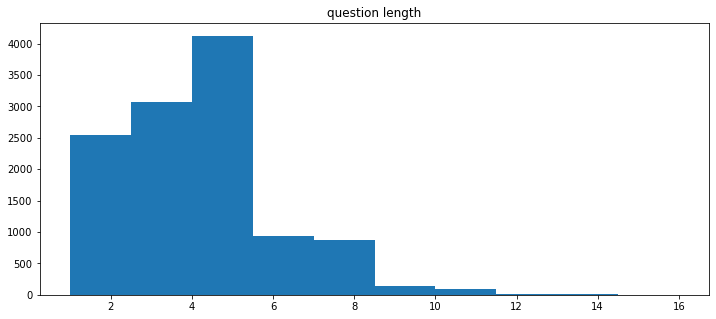

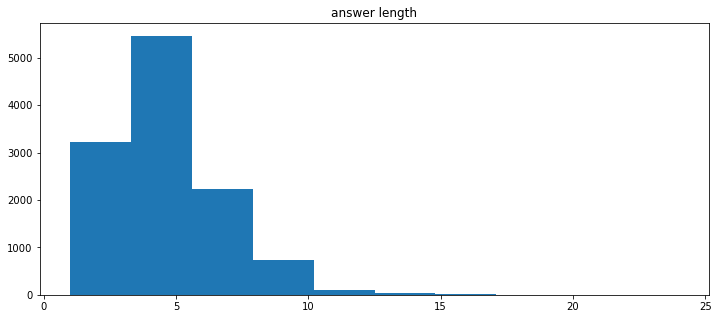

In [112]:
import matplotlib.pyplot as plt 

question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print(max(question_len))
print(max(answer_len))

plt.figure(figsize=(12, 5))
plt.hist(question_len)
plt.title('question length')

plt.figure(figsize=(12, 5))
plt.hist(answer_len)
plt.title('answer length')

**분포를 확인했으나, 전체 데이터를 사용하기 위해 최대 길이는 30으로 하겠습니다.**

In [113]:
MAX_LENGTH = 30
print(MAX_LENGTH)

30


In [128]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        
        tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
        tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')        
    
    return tokenized_inputs, tokenized_outputs

In [126]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [130]:
questions, answers = tokenize_and_filter(questions, answers)

print('단어장 크기:', (VOCAB_SIZE))
print('필터링 후 질문 샘플 개수:{}'.format(len(questions)))
print('필터링 후 답변 샘플 개수:{}'.format(len(answers)))

TypeError: Expected binary or unicode string, got array([8170, 7909, 4200, 3054,   38, 8171,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

# 루브릭 평가
---
1. **의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.**   

    - 학습과정 시각화를 통해 accuracy, loss가 잘 수렴하는 것을 확인했다.


2. **데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.**

    - 레이어를 수정하면서 성능개선을 위해 실험하였다.
     
     
3. **실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.** 

    - accuracy를 높이고, recall도 더 높일 수 있었다.

    
    
# 회고
---
## 어려웠던 점 
- 도메인 지식 부족
    - 폐렴 이미지에 대한 설명을 확인했지만, 사실 구분하기에는 어려웠다.
    
## 알게된 점 
- 데이터 불균형 처리
    - class_weight를 통해 레이블 별 가중치를 다르게 할 수 있다는 것을 배웠다.

## 다짐
- 자주 사용했던 모델이어서 금방 구현할 수 있었다. 